# Importation des libraies

In [3]:
%pip install jupyterthemes

import nltk
nltk.download('punkt')

import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import nltk
import re
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
# import keras
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding, Input, LSTM, Conv1D, MaxPool1D, Bidirectional
from tensorflow.keras.models import Model
from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False) 
# setting the style of the notebook to be monokai theme  
# this line of code is important to ensure that we are able to see the x and y axes clearly
# If you don't run this code line, you will notice that the xlabel and ylabel on any plot is black on black and it will be hard to see them. 


Note: you may need to restart the kernel to use updated packages.


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\yohar\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Exploration des données

In [4]:
#Chargement des deux datasets
df_fake = pd.read_csv('Fake.csv')
df_true = pd.read_csv('True.csv')

In [5]:
print("Number of fake news samples:", len(df_fake))
print("Number of true news samples:", len(df_true))

Number of fake news samples: 23481
Number of true news samples: 21417


In [6]:
print("Les valeurs nulles dans Fake:\n", df_fake.isnull().sum())
print("\nUtilisation de la mémoire:")
print(df_fake.memory_usage(deep=True))

Les valeurs nulles dans Fake:
 title      0
text       0
subject    0
date       0
dtype: int64

Utilisation de la mémoire:
Index           128
title       5380518
text       61153828
subject     1507065
date        1646426
dtype: int64


In [7]:
print("\nLes valeures nulles dans True:\n", df_true.isnull().sum())
print("\nUtilisation de la mémoire dans True:")
print(df_true.memory_usage(deep=True))


Les valeures nulles dans True:
 title      0
text       0
subject    0
date       0
dtype: int64

Utilisation de la mémoire dans True:
Index           128
title       2609581
text       81025844
subject     1447338
date        1578819
dtype: int64


In [8]:
df_fake

title  \
0       Donald Trump Sends Out Embarrassing New Year’...   
1       Drunk Bragging Trump Staffer Started Russian ...   
2       Sheriff David Clarke Becomes An Internet Joke...   
3       Trump Is So Obsessed He Even Has Obama’s Name...   
4       Pope Francis Just Called Out Donald Trump Dur...   
...                                                  ...   
23476  McPain: John McCain Furious That Iran Treated ...   
23477  JUSTICE? Yahoo Settles E-mail Privacy Class-ac...   
23478  Sunnistan: US and Allied ‘Safe Zone’ Plan to T...   
23479  How to Blow $700 Million: Al Jazeera America F...   
23480  10 U.S. Navy Sailors Held by Iranian Military ...   

                                                    text      subject  \
0      Donald Trump just couldn t wish all Americans ...         News   
1      House Intelligence Committee Chairman Devin Nu...         News   
2      On Friday, it was revealed that former Milwauk...         News   
3      On Christmas day, Donald Trump announced that ...         News   
4      Pope Francis used his annual Christmas Day mes...         News   
...                                                  ...          ...   
23476  21st Century Wire says As 21WIRE reported earl...  Middle-east   
23477  21st Century Wire says It s a familiar theme. ...  Middle-east   
23478  Patrick Henningsen  21st Century WireRemember ...  Middle-east   
23479  21st Century Wire says Al Jazeera America will...  Middle-east   
23480  21st Century Wire says As 21WIRE predicted in ...  Middle-east   

                    date  
0      December 31, 2017  
1      December 31, 2017  
2      December 30, 2017  
3      December 29, 2017  
4      December 25, 2017  
...                  ...  
23476   January 16, 2016  
23477   January 16, 2016  
23478   January 15, 2016  
23479   January 14, 2016  
23480   January 12, 2016  

[23481 rows x 4 columns]

In [9]:
df_true

title  \
0      As U.S. budget fight looms, Republicans flip t...   
1      U.S. military to accept transgender recruits o...   
2      Senior U.S. Republican senator: 'Let Mr. Muell...   
3      FBI Russia probe helped by Australian diplomat...   
4      Trump wants Postal Service to charge 'much mor...   
...                                                  ...   
21412  'Fully committed' NATO backs new U.S. approach...   
21413  LexisNexis withdrew two products from Chinese ...   
21414  Minsk cultural hub becomes haven from authorities   
21415  Vatican upbeat on possibility of Pope Francis ...   
21416  Indonesia to buy $1.14 billion worth of Russia...   

                                                    text       subject  \
0      WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1      WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2      WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
3      WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   
4      SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews   
...                                                  ...           ...   
21412  BRUSSELS (Reuters) - NATO allies on Tuesday we...     worldnews   
21413  LONDON (Reuters) - LexisNexis, a provider of l...     worldnews   
21414  MINSK (Reuters) - In the shadow of disused Sov...     worldnews   
21415  MOSCOW (Reuters) - Vatican Secretary of State ...     worldnews   
21416  JAKARTA (Reuters) - Indonesia will buy 11 Sukh...     worldnews   

                     date  
0      December 31, 2017   
1      December 29, 2017   
2      December 31, 2017   
3      December 30, 2017   
4      December 29, 2017   
...                   ...  
21412    August 22, 2017   
21413    August 22, 2017   
21414    August 22, 2017   
21415    August 22, 2017   
21416    August 22, 2017   

[21417 rows x 4 columns]

# Feature Engenering

In [10]:
#Creation d'une nouvelle colonne isfake
df_true['isFake'] = 0
df_fake['isFake'] = 1

In [11]:
#Concaténation des deux datasets
df = pd.concat([df_true, df_fake], axis=0, ignore_index=True)
df

title  \
0      As U.S. budget fight looms, Republicans flip t...   
1      U.S. military to accept transgender recruits o...   
2      Senior U.S. Republican senator: 'Let Mr. Muell...   
3      FBI Russia probe helped by Australian diplomat...   
4      Trump wants Postal Service to charge 'much mor...   
...                                                  ...   
44893  McPain: John McCain Furious That Iran Treated ...   
44894  JUSTICE? Yahoo Settles E-mail Privacy Class-ac...   
44895  Sunnistan: US and Allied ‘Safe Zone’ Plan to T...   
44896  How to Blow $700 Million: Al Jazeera America F...   
44897  10 U.S. Navy Sailors Held by Iranian Military ...   

                                                    text       subject  \
0      WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1      WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2      WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
3      WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   
4      SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews   
...                                                  ...           ...   
44893  21st Century Wire says As 21WIRE reported earl...   Middle-east   
44894  21st Century Wire says It s a familiar theme. ...   Middle-east   
44895  Patrick Henningsen  21st Century WireRemember ...   Middle-east   
44896  21st Century Wire says Al Jazeera America will...   Middle-east   
44897  21st Century Wire says As 21WIRE predicted in ...   Middle-east   

                     date  isFake  
0      December 31, 2017        0  
1      December 29, 2017        0  
2      December 31, 2017        0  
3      December 30, 2017        0  
4      December 29, 2017        0  
...                   ...     ...  
44893    January 16, 2016       1  
44894    January 16, 2016       1  
44895    January 15, 2016       1  
44896    January 14, 2016       1  
44897    January 12, 2016       1  

[44898 rows x 5 columns]

In [12]:
#Suppresion de la colonne date
df.drop(columns=['date'], inplace=True)

In [13]:
#Creation d'une nouvelle colonne 'originale' qui est une combinaison de title et text
df['original'] = df['title'] + ' ' + df['text']
df

title  \
0      As U.S. budget fight looms, Republicans flip t...   
1      U.S. military to accept transgender recruits o...   
2      Senior U.S. Republican senator: 'Let Mr. Muell...   
3      FBI Russia probe helped by Australian diplomat...   
4      Trump wants Postal Service to charge 'much mor...   
...                                                  ...   
44893  McPain: John McCain Furious That Iran Treated ...   
44894  JUSTICE? Yahoo Settles E-mail Privacy Class-ac...   
44895  Sunnistan: US and Allied ‘Safe Zone’ Plan to T...   
44896  How to Blow $700 Million: Al Jazeera America F...   
44897  10 U.S. Navy Sailors Held by Iranian Military ...   

                                                    text       subject  \
0      WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1      WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2      WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
3      WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   
4      SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews   
...                                                  ...           ...   
44893  21st Century Wire says As 21WIRE reported earl...   Middle-east   
44894  21st Century Wire says It s a familiar theme. ...   Middle-east   
44895  Patrick Henningsen  21st Century WireRemember ...   Middle-east   
44896  21st Century Wire says Al Jazeera America will...   Middle-east   
44897  21st Century Wire says As 21WIRE predicted in ...   Middle-east   

       isFake                                           original  
0           0  As U.S. budget fight looms, Republicans flip t...  
1           0  U.S. military to accept transgender recruits o...  
2           0  Senior U.S. Republican senator: 'Let Mr. Muell...  
3           0  FBI Russia probe helped by Australian diplomat...  
4           0  Trump wants Postal Service to charge 'much mor...  
...       ...                                                ...  
44893       1  McPain: John McCain Furious That Iran Treated ...  
44894       1  JUSTICE? Yahoo Settles E-mail Privacy Class-ac...  
44895       1  Sunnistan: US and Allied ‘Safe Zone’ Plan to T...  
44896       1  How to Blow $700 Million: Al Jazeera America F...  
44897       1  10 U.S. Navy Sailors Held by Iranian Military ...  

[44898 rows x 5 columns]

In [14]:
df['original'][0]

'As U.S. budget fight looms, Republicans flip their fiscal script WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal conservative” on Sunday and urged budget restraint in 2018. In keeping with a sharp pivot under way among Republicans, U.S. Representative Mark Meadows, speaking on CBS’ “Face the Nation,” drew a hard line on federal spending, which lawmakers are bracing to do battle over in January. When they return from the holidays on Wednesday, lawmakers will begin trying to pass a federal budget in a fight likely to be linked to other issues, such as immigration policy, even as the November congressional election campaigns approach in which Republicans will seek to keep control of Congress. President Donald Trump and his Republicans want a big budget increase in military spending, while Democrats also want proportional increases for non

# Nettoyage des données

In [15]:
#Téléchargement du package stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yohar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [16]:
# Obtention de la liste des stopwords
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
stop_words.update(['said', 'says', 'say', 'will', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'ten'])
stop_words.update(['from', 'subject', 're', 'edu', 'use'])

In [17]:
stop_words

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'edu',
 'eight',
 'few',
 'five',
 'for',
 'four',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 "he'd",
 "he'll",
 "he's",
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 "i'd",
 "i'll",
 "i'm",
 "i've",
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it'd",
 "it'll",
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'nine',
 'no',
 'nor',
 'not',
 'no

In [18]:
# Suppression des stopwords et suppression des mots de longueur inférieure à 3
def remove_stopwords(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3 and token not in stop_words:
            result.append(token)
            
    return result

In [19]:
#Appliquons cette fonction sur la colonne originale
df['clean'] = df['original'].apply(remove_stopwords)
df['clean'][0]

['budget',
 'fight',
 'looms',
 'republicans',
 'flip',
 'fiscal',
 'script',
 'washington',
 'reuters',
 'head',
 'conservative',
 'republican',
 'faction',
 'congress',
 'voted',
 'month',
 'huge',
 'expansion',
 'national',
 'debt',
 'cuts',
 'called',
 'fiscal',
 'conservative',
 'sunday',
 'urged',
 'budget',
 'restraint',
 'keeping',
 'sharp',
 'pivot',
 'republicans',
 'representative',
 'mark',
 'meadows',
 'speaking',
 'face',
 'nation',
 'drew',
 'hard',
 'line',
 'federal',
 'spending',
 'lawmakers',
 'bracing',
 'battle',
 'january',
 'return',
 'holidays',
 'wednesday',
 'lawmakers',
 'begin',
 'trying',
 'pass',
 'federal',
 'budget',
 'fight',
 'likely',
 'linked',
 'issues',
 'immigration',
 'policy',
 'november',
 'congressional',
 'election',
 'campaigns',
 'approach',
 'republicans',
 'seek',
 'control',
 'congress',
 'president',
 'donald',
 'trump',
 'republicans',
 'want',
 'budget',
 'increase',
 'military',
 'spending',
 'democrats',
 'want',
 'proportional',
 '

In [20]:
df

title  \
0      As U.S. budget fight looms, Republicans flip t...   
1      U.S. military to accept transgender recruits o...   
2      Senior U.S. Republican senator: 'Let Mr. Muell...   
3      FBI Russia probe helped by Australian diplomat...   
4      Trump wants Postal Service to charge 'much mor...   
...                                                  ...   
44893  McPain: John McCain Furious That Iran Treated ...   
44894  JUSTICE? Yahoo Settles E-mail Privacy Class-ac...   
44895  Sunnistan: US and Allied ‘Safe Zone’ Plan to T...   
44896  How to Blow $700 Million: Al Jazeera America F...   
44897  10 U.S. Navy Sailors Held by Iranian Military ...   

                                                    text       subject  \
0      WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1      WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2      WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
3      WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   
4      SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews   
...                                                  ...           ...   
44893  21st Century Wire says As 21WIRE reported earl...   Middle-east   
44894  21st Century Wire says It s a familiar theme. ...   Middle-east   
44895  Patrick Henningsen  21st Century WireRemember ...   Middle-east   
44896  21st Century Wire says Al Jazeera America will...   Middle-east   
44897  21st Century Wire says As 21WIRE predicted in ...   Middle-east   

       isFake                                           original  \
0           0  As U.S. budget fight looms, Republicans flip t...   
1           0  U.S. military to accept transgender recruits o...   
2           0  Senior U.S. Republican senator: 'Let Mr. Muell...   
3           0  FBI Russia probe helped by Australian diplomat...   
4           0  Trump wants Postal Service to charge 'much mor...   
...       ...                                                ...   
44893       1  McPain: John McCain Furious That Iran Treated ...   
44894       1  JUSTICE? Yahoo Settles E-mail Privacy Class-ac...   
44895       1  Sunnistan: US and Allied ‘Safe Zone’ Plan to T...   
44896       1  How to Blow $700 Million: Al Jazeera America F...   
44897       1  10 U.S. Navy Sailors Held by Iranian Military ...   

                                                   clean  
0      [budget, fight, looms, republicans, flip, fisc...  
1      [military, accept, transgender, recruits, mond...  
2      [senior, republican, senator, mueller, washing...  
3      [russia, probe, helped, australian, diplomat, ...  
4      [trump, wants, postal, service, charge, amazon...  
...                                                  ...  
44893  [mcpain, john, mccain, furious, iran, treated,...  
44894  [justice, yahoo, settles, mail, privacy, class...  
44895  [sunnistan, allied, safe, zone, plan, territor...  
44896  [blow, million, jazeera, america, finally, cal...  
44897  [navy, sailors, held, iranian, military, signs...  

[44898 rows x 6 columns]

In [21]:
print(df['clean'][0])

['budget', 'fight', 'looms', 'republicans', 'flip', 'fiscal', 'script', 'washington', 'reuters', 'head', 'conservative', 'republican', 'faction', 'congress', 'voted', 'month', 'huge', 'expansion', 'national', 'debt', 'cuts', 'called', 'fiscal', 'conservative', 'sunday', 'urged', 'budget', 'restraint', 'keeping', 'sharp', 'pivot', 'republicans', 'representative', 'mark', 'meadows', 'speaking', 'face', 'nation', 'drew', 'hard', 'line', 'federal', 'spending', 'lawmakers', 'bracing', 'battle', 'january', 'return', 'holidays', 'wednesday', 'lawmakers', 'begin', 'trying', 'pass', 'federal', 'budget', 'fight', 'likely', 'linked', 'issues', 'immigration', 'policy', 'november', 'congressional', 'election', 'campaigns', 'approach', 'republicans', 'seek', 'control', 'congress', 'president', 'donald', 'trump', 'republicans', 'want', 'budget', 'increase', 'military', 'spending', 'democrats', 'want', 'proportional', 'increases', 'defense', 'discretionary', 'spending', 'programs', 'support', 'educati

In [22]:
print(df['original'][0])

As U.S. budget fight looms, Republicans flip their fiscal script WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal conservative” on Sunday and urged budget restraint in 2018. In keeping with a sharp pivot under way among Republicans, U.S. Representative Mark Meadows, speaking on CBS’ “Face the Nation,” drew a hard line on federal spending, which lawmakers are bracing to do battle over in January. When they return from the holidays on Wednesday, lawmakers will begin trying to pass a federal budget in a fight likely to be linked to other issues, such as immigration policy, even as the November congressional election campaigns approach in which Republicans will seek to keep control of Congress. President Donald Trump and his Republicans want a big budget increase in military spending, while Democrats also want proportional increases for non-

In [23]:
# Nombre de mots presents dans clean
list_of_words = []
for i in df['clean']:
    for j in i:
        list_of_words.append(j)

In [24]:
list_of_words

['budget',
 'fight',
 'looms',
 'republicans',
 'flip',
 'fiscal',
 'script',
 'washington',
 'reuters',
 'head',
 'conservative',
 'republican',
 'faction',
 'congress',
 'voted',
 'month',
 'huge',
 'expansion',
 'national',
 'debt',
 'cuts',
 'called',
 'fiscal',
 'conservative',
 'sunday',
 'urged',
 'budget',
 'restraint',
 'keeping',
 'sharp',
 'pivot',
 'republicans',
 'representative',
 'mark',
 'meadows',
 'speaking',
 'face',
 'nation',
 'drew',
 'hard',
 'line',
 'federal',
 'spending',
 'lawmakers',
 'bracing',
 'battle',
 'january',
 'return',
 'holidays',
 'wednesday',
 'lawmakers',
 'begin',
 'trying',
 'pass',
 'federal',
 'budget',
 'fight',
 'likely',
 'linked',
 'issues',
 'immigration',
 'policy',
 'november',
 'congressional',
 'election',
 'campaigns',
 'approach',
 'republicans',
 'seek',
 'control',
 'congress',
 'president',
 'donald',
 'trump',
 'republicans',
 'want',
 'budget',
 'increase',
 'military',
 'spending',
 'democrats',
 'want',
 'proportional',
 '

In [25]:
len(list_of_words)

9127432

In [26]:
# Valeurs uniques dans la liste
total_word = len(set(list_of_words))
total_word

108701

In [27]:
# Creation d'un nouvelle colonne clean_joined
df['clean_joined'] = df['clean'].apply(lambda x: ' '.join(x))

In [28]:
df

title  \
0      As U.S. budget fight looms, Republicans flip t...   
1      U.S. military to accept transgender recruits o...   
2      Senior U.S. Republican senator: 'Let Mr. Muell...   
3      FBI Russia probe helped by Australian diplomat...   
4      Trump wants Postal Service to charge 'much mor...   
...                                                  ...   
44893  McPain: John McCain Furious That Iran Treated ...   
44894  JUSTICE? Yahoo Settles E-mail Privacy Class-ac...   
44895  Sunnistan: US and Allied ‘Safe Zone’ Plan to T...   
44896  How to Blow $700 Million: Al Jazeera America F...   
44897  10 U.S. Navy Sailors Held by Iranian Military ...   

                                                    text       subject  \
0      WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1      WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2      WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
3      WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   
4      SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews   
...                                                  ...           ...   
44893  21st Century Wire says As 21WIRE reported earl...   Middle-east   
44894  21st Century Wire says It s a familiar theme. ...   Middle-east   
44895  Patrick Henningsen  21st Century WireRemember ...   Middle-east   
44896  21st Century Wire says Al Jazeera America will...   Middle-east   
44897  21st Century Wire says As 21WIRE predicted in ...   Middle-east   

       isFake                                           original  \
0           0  As U.S. budget fight looms, Republicans flip t...   
1           0  U.S. military to accept transgender recruits o...   
2           0  Senior U.S. Republican senator: 'Let Mr. Muell...   
3           0  FBI Russia probe helped by Australian diplomat...   
4           0  Trump wants Postal Service to charge 'much mor...   
...       ...                                                ...   
44893       1  McPain: John McCain Furious That Iran Treated ...   
44894       1  JUSTICE? Yahoo Settles E-mail Privacy Class-ac...   
44895       1  Sunnistan: US and Allied ‘Safe Zone’ Plan to T...   
44896       1  How to Blow $700 Million: Al Jazeera America F...   
44897       1  10 U.S. Navy Sailors Held by Iranian Military ...   

                                                   clean  \
0      [budget, fight, looms, republicans, flip, fisc...   
1      [military, accept, transgender, recruits, mond...   
2      [senior, republican, senator, mueller, washing...   
3      [russia, probe, helped, australian, diplomat, ...   
4      [trump, wants, postal, service, charge, amazon...   
...                                                  ...   
44893  [mcpain, john, mccain, furious, iran, treated,...   
44894  [justice, yahoo, settles, mail, privacy, class...   
44895  [sunnistan, allied, safe, zone, plan, territor...   
44896  [blow, million, jazeera, america, finally, cal...   
44897  [navy, sailors, held, iranian, military, signs...   

                                            clean_joined  
0      budget fight looms republicans flip fiscal scr...  
1      military accept transgender recruits monday pe...  
2      senior republican senator mueller washington r...  
3      russia probe helped australian diplomat washin...  
4      trump wants postal service charge amazon shipm...  
...                                                  ...  
44893  mcpain john mccain furious iran treated sailor...  
44894  justice yahoo settles mail privacy class actio...  
44895  sunnistan allied safe zone plan territorial bo...  
44896  blow million jazeera america finally calls qui...  
44897  navy sailors held iranian military signs neoco...  

[44898 rows x 7 columns]

In [29]:
# Visualisation de 3 exemples de news avant et après le préprocessing
sample_indices = [0, 100, 200]  # Choix arbitraire de 3 indices

for idx in sample_indices:
    print(f"--- Sample {idx} ---")
    print("Original:")
    print(df.loc[idx, 'original'])
    print("\nCleaned (joined):")
    print(df.loc[idx, 'clean_joined'])
    print("\n")

--- Sample 0 ---
Original:
As U.S. budget fight looms, Republicans flip their fiscal script WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal conservative” on Sunday and urged budget restraint in 2018. In keeping with a sharp pivot under way among Republicans, U.S. Representative Mark Meadows, speaking on CBS’ “Face the Nation,” drew a hard line on federal spending, which lawmakers are bracing to do battle over in January. When they return from the holidays on Wednesday, lawmakers will begin trying to pass a federal budget in a fight likely to be linked to other issues, such as immigration policy, even as the November congressional election campaigns approach in which Republicans will seek to keep control of Congress. President Donald Trump and his Republicans want a big budget increase in military spending, while Democrats also want prop

# Visualisation de notre dataset nettoyé

In [30]:
df

title  \
0      As U.S. budget fight looms, Republicans flip t...   
1      U.S. military to accept transgender recruits o...   
2      Senior U.S. Republican senator: 'Let Mr. Muell...   
3      FBI Russia probe helped by Australian diplomat...   
4      Trump wants Postal Service to charge 'much mor...   
...                                                  ...   
44893  McPain: John McCain Furious That Iran Treated ...   
44894  JUSTICE? Yahoo Settles E-mail Privacy Class-ac...   
44895  Sunnistan: US and Allied ‘Safe Zone’ Plan to T...   
44896  How to Blow $700 Million: Al Jazeera America F...   
44897  10 U.S. Navy Sailors Held by Iranian Military ...   

                                                    text       subject  \
0      WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1      WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2      WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
3      WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   
4      SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews   
...                                                  ...           ...   
44893  21st Century Wire says As 21WIRE reported earl...   Middle-east   
44894  21st Century Wire says It s a familiar theme. ...   Middle-east   
44895  Patrick Henningsen  21st Century WireRemember ...   Middle-east   
44896  21st Century Wire says Al Jazeera America will...   Middle-east   
44897  21st Century Wire says As 21WIRE predicted in ...   Middle-east   

       isFake                                           original  \
0           0  As U.S. budget fight looms, Republicans flip t...   
1           0  U.S. military to accept transgender recruits o...   
2           0  Senior U.S. Republican senator: 'Let Mr. Muell...   
3           0  FBI Russia probe helped by Australian diplomat...   
4           0  Trump wants Postal Service to charge 'much mor...   
...       ...                                                ...   
44893       1  McPain: John McCain Furious That Iran Treated ...   
44894       1  JUSTICE? Yahoo Settles E-mail Privacy Class-ac...   
44895       1  Sunnistan: US and Allied ‘Safe Zone’ Plan to T...   
44896       1  How to Blow $700 Million: Al Jazeera America F...   
44897       1  10 U.S. Navy Sailors Held by Iranian Military ...   

                                                   clean  \
0      [budget, fight, looms, republicans, flip, fisc...   
1      [military, accept, transgender, recruits, mond...   
2      [senior, republican, senator, mueller, washing...   
3      [russia, probe, helped, australian, diplomat, ...   
4      [trump, wants, postal, service, charge, amazon...   
...                                                  ...   
44893  [mcpain, john, mccain, furious, iran, treated,...   
44894  [justice, yahoo, settles, mail, privacy, class...   
44895  [sunnistan, allied, safe, zone, plan, territor...   
44896  [blow, million, jazeera, america, finally, cal...   
44897  [navy, sailors, held, iranian, military, signs...   

                                            clean_joined  
0      budget fight looms republicans flip fiscal scr...  
1      military accept transgender recruits monday pe...  
2      senior republican senator mueller washington r...  
3      russia probe helped australian diplomat washin...  
4      trump wants postal service charge amazon shipm...  
...                                                  ...  
44893  mcpain john mccain furious iran treated sailor...  
44894  justice yahoo settles mail privacy class actio...  
44895  sunnistan allied safe zone plan territorial bo...  
44896  blow million jazeera america finally calls qui...  
44897  navy sailors held iranian military signs neoco...  

[44898 rows x 7 columns]

C:\Users\yohar\AppData\Local\Temp\ipykernel_51856\2384293957.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='subject', data=df, palette='Set2')


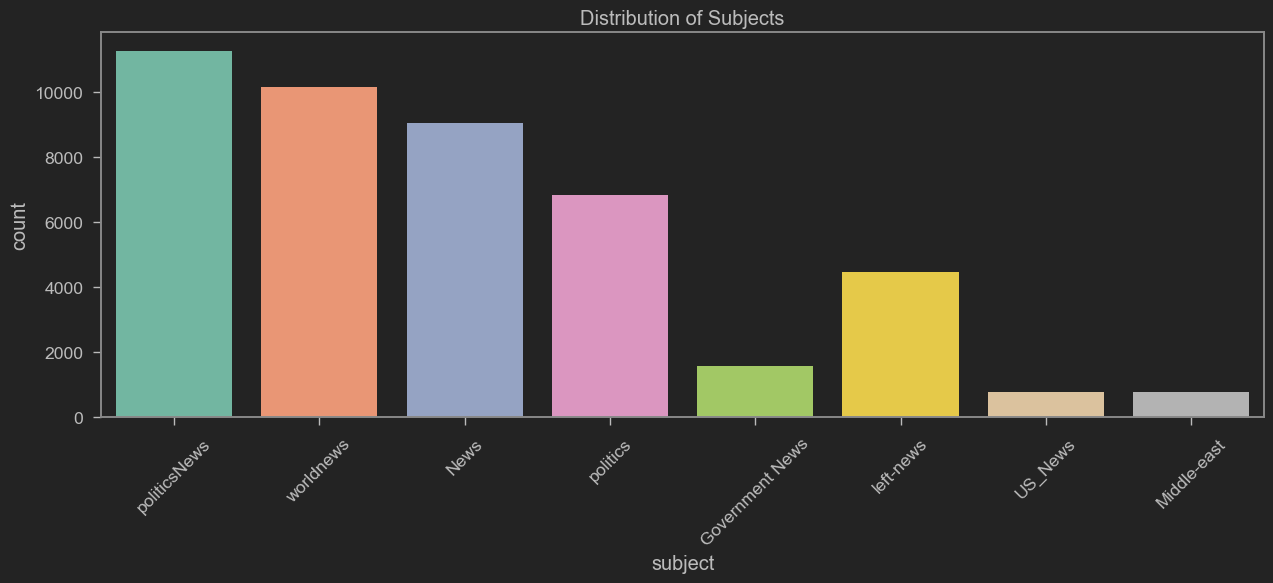

In [31]:
#Affichage de Subjects
plt.figure(figsize=(15, 5))
sns.countplot(x='subject', data=df, palette='Set2')
plt.title('Distribution of Subjects')
plt.xticks(rotation=45)
plt.show()


C:\Users\yohar\AppData\Local\Temp\ipykernel_51856\3805289726.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='isFake', data=df, palette='Set2')


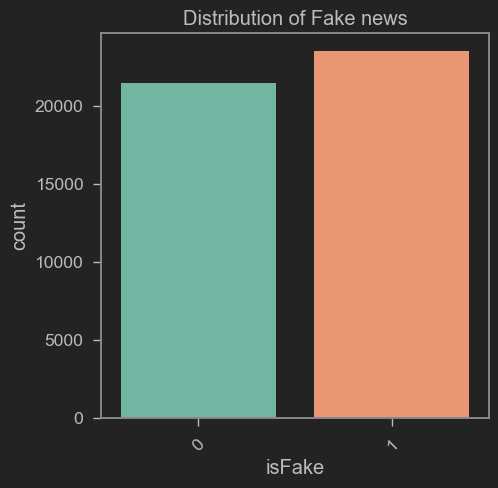

In [32]:
#Affichage de isFake
plt.figure(figsize=(5, 5))
sns.countplot(x='isFake', data=df, palette='Set2')
plt.title('Distribution of Fake news')
plt.xticks(rotation=45)
plt.show()

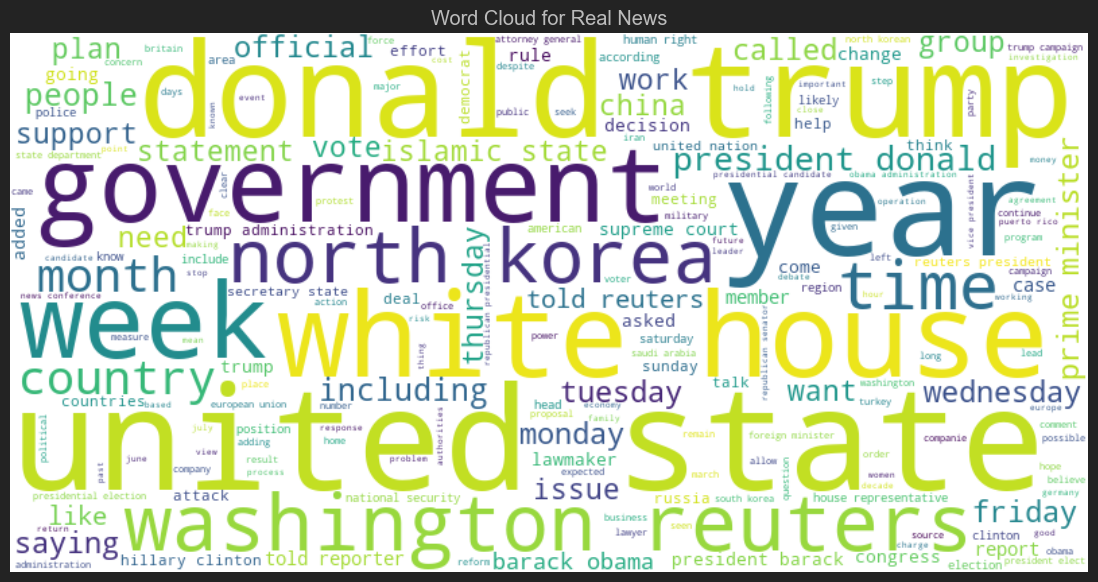

In [33]:
# Les mots les plus récurrent (isFake == 0)
real_text = ' '.join(df[df['isFake'] == 0]['clean_joined'])

wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=STOPWORDS).generate(real_text)

plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Real News')
plt.show()

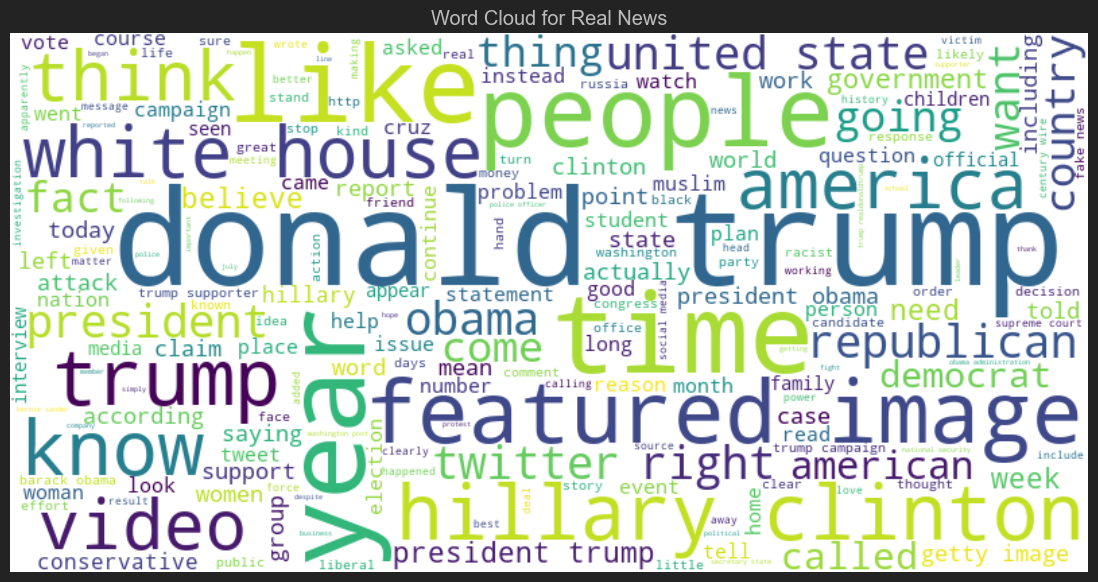

In [34]:
# Les mots les plus récurrent (isFake == 1)
real_text = ' '.join(df[df['isFake'] == 1]['clean_joined'])

wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=STOPWORDS).generate(real_text)

plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Real News')
plt.show()

In [35]:
import nltk
nltk.download('punkt_tab')

nltk.word_tokenize(df['clean_joined'][2])

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\yohar\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


['senior',
 'republican',
 'senator',
 'mueller',
 'washington',
 'reuters',
 'special',
 'counsel',
 'investigation',
 'links',
 'russia',
 'president',
 'trump',
 'election',
 'campaign',
 'continue',
 'interference',
 'despite',
 'calls',
 'trump',
 'administration',
 'allies',
 'republican',
 'lawmakers',
 'shut',
 'prominent',
 'republican',
 'senator',
 'sunday',
 'lindsey',
 'graham',
 'serves',
 'senate',
 'armed',
 'forces',
 'judiciary',
 'committees',
 'department',
 'justice',
 'special',
 'counsel',
 'robert',
 'mueller',
 'needs',
 'carry',
 'russia',
 'investigation',
 'political',
 'interference',
 'investigation',
 'forward',
 'investigation',
 'conducted',
 'political',
 'influence',
 'graham',
 'face',
 'nation',
 'news',
 'program',
 'need',
 'mueller',
 'think',
 'right',
 'right',
 'time',
 'question',
 'russia',
 'interfered',
 'election',
 'trump',
 'campaign',
 'links',
 'ordinated',
 'effort',
 'loomed',
 'white',
 'house',
 'trump',
 'took',
 'office',
 'janu

In [36]:
# Obtention de la taille maximal du document (news) dont on a besoins pour creer le word embedding
max_length = -1
for i in df['clean_joined']:
    tokens = nltk.word_tokenize(i)
    if(max_length<len(tokens)):
        max_length = len(tokens)
print("Max length of document:", max_length)


Max length of document: 4404


In [37]:
# visualisation de la distribution du nombre de mots dans un texte
import plotly.express as px

word_counts = [len(nltk.word_tokenize(text)) for text in df['clean_joined']]
fig = px.histogram(x=word_counts, nbins=100)
fig.update_layout(title_text='Distribution of Number of Words in Texts', xaxis_title_text='Number of Words', yaxis_title_text='Count')
fig.show()

# Preparation des données pour notre model

In [38]:
#Separation des données en train et test
from sklearn.model_selection import train_test_split
X = df['clean_joined']
y = df['isFake']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [39]:
from nltk import word_tokenize

In [40]:
#Creation d'un Tokenizer pour tokenizer les mots et creer des sequences de mots tokenized
tokenizer = Tokenizer(num_words=total_word)
tokenizer.fit_on_texts(X_train)
train_sequences = tokenizer.texts_to_sequences(X_train)
test_sequences = tokenizer.texts_to_sequences(X_test)



In [41]:
len(train_sequences)

35918

In [42]:
train_sequences

[[23,
  966,
  967,
  23,
  3141,
  835,
  2854,
  244,
  135,
  88,
  907,
  23,
  966,
  3627,
  1151,
  162,
  1206,
  1250,
  102,
  23,
  7875,
  6,
  6846,
  10188,
  835,
  20076,
  23,
  43100,
  5027,
  30562,
  135,
  7265,
  6,
  19120,
  1480,
  6,
  18,
  835,
  20076,
  6847,
  130,
  135,
  815,
  1248,
  7423,
  10537,
  961,
  176,
  817,
  4861,
  27401,
  781,
  18,
  20076,
  28800,
  5201,
  65104,
  65105,
  1014,
  1048,
  5027,
  30562,
  1767,
  111,
  20076,
  6,
  815,
  24084,
  7875,
  88,
  16,
  835,
  2854,
  65106,
  460,
  1307,
  5918,
  23,
  6,
  20,
  111,
  20076,
  970,
  51,
  23,
  16,
  20076,
  23,
  6,
  1930,
  135,
  19120,
  213,
  23,
  6,
  1489,
  19120,
  768,
  265,
  777,
  3976,
  15788,
  135,
  28,
  12601,
  20076,
  2854,
  11463,
  30562,
  6,
  1431,
  970],
 [137,
  158,
  455,
  2659,
  646,
  218,
  729,
  8,
  137,
  226,
  250,
  1968,
  188,
  11,
  158,
  2145,
  45,
  85,
  1752,
  140,
  4223,
  324,
  252,
  2659,
 

In [43]:
len(test_sequences)

8980

In [44]:
# Affich des deux versions tokenized
for i in range(5):
    print("Original:", X_train.iloc[i])
    print("Tokenized:", train_sequences[i])
    print("\n")

Original: hillary lies remember hillary disclosed named famous person story long series hillary lies exposing couple months decade piece senator hillary rodham clinton informal biography named edmund hillary conqueror mount everest story recounted clinton autobiography yesterday clinton campaign named edmund sweet family story mother shared inspire greatness daughter great results jennifer hanley spokeswoman campaign edmund sherpa guide tenzing norgay reach summit mount everest shortly meeting edmund clinton mother dorothy rodham long told named famous mountaineer thought supposed spell hillary clinton time meeting edmund born called hillary told edmund hillary clinton repeated story autobiography life hillary clinton mention autobiography living history published hole poked story years cyberspace edmund famous climbing everest clinton happens born
Tokenized: [23, 966, 967, 23, 3141, 835, 2854, 244, 135, 88, 907, 23, 966, 3627, 1151, 162, 1206, 1250, 102, 23, 7875, 6, 6846, 10188, 835,

In [45]:
#Standardisation de la taille des sequences
padded_train = pad_sequences(train_sequences, maxlen=4405, padding='post',truncating='post')
padded_test = pad_sequences(test_sequences, maxlen=4405, truncating='post')

In [46]:
#Affichage des sequences
for i,doc in enumerate(padded_train[:2]):
    print(f"Document {i+1}:")
    print("Tokenized:", doc)
    print("Original:", X_train.iloc[i])
    print("\n")


Document 1:
Tokenized: [ 23 966 967 ...   0   0   0]
Original: hillary lies remember hillary disclosed named famous person story long series hillary lies exposing couple months decade piece senator hillary rodham clinton informal biography named edmund hillary conqueror mount everest story recounted clinton autobiography yesterday clinton campaign named edmund sweet family story mother shared inspire greatness daughter great results jennifer hanley spokeswoman campaign edmund sherpa guide tenzing norgay reach summit mount everest shortly meeting edmund clinton mother dorothy rodham long told named famous mountaineer thought supposed spell hillary clinton time meeting edmund born called hillary told edmund hillary clinton repeated story autobiography life hillary clinton mention autobiography living history published hole poked story years cyberspace edmund famous climbing everest clinton happens born


Document 2:
Tokenized: [137 158 455 ...   0   0   0]
Original: leaders likely ahead 

# Mise en place du model

In [ ]:
model = Sequential()
model.add(Embedding(total_word, output_dim=128))


model.add(Bidirectional(LSTM(128)))


model.add(Dense(128, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

In [48]:
total_word

108701

In [49]:
y_train = np.array(y_train)

In [ ]:
# model.fit(padded_train, y_train, epochs=2, batch_size=64, validation_split=0.1)

# Perfermance de notre model

In [51]:
# Faire des predictions sur le test set
y_pred = model.predict(padded_test)

281/281 ━━━━━━━━━━━━━━━━━━━━ 182s 645ms/step


In [52]:
#Si la perdiction est supérieure à 0.5, on considère que c'est un fake news
prediction = []
for i in y_pred:
    if i > 0.5:
        prediction.append(1)
    else:
        prediction.append(0)

In [53]:
# Obtention de l'accuracy
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(list(y_test), prediction)
print("Accuracy:", accuracy)

Accuracy: 0.538641425389755


<Axes: >

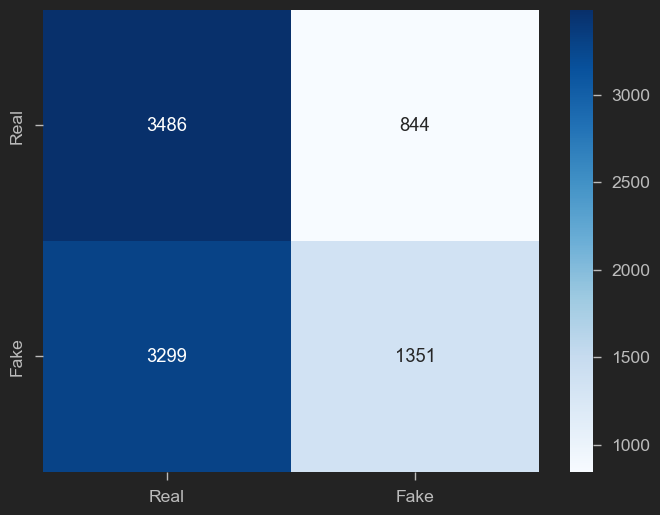

In [54]:
# Matrice de confusion de la prediction
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(list(y_test), prediction)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])